In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [2]:

from plotting import *
plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
basePath = '../export'
basePath = os.path.expanduser(basePath)

In [5]:
simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
for i, c in enumerate(simulationFiles):
    print(i ,c)

0 ../export/dambreak - 2023-02-13_12-54-39.hdf5
1 ../export/dambreak - 2023-02-13_11-57-41.hdf5


In [6]:
simulationFiles  = [simulationFiles[0]]

In [7]:
training = []
validation = []
testing = []


for s in simulationFiles:    
    _, train, valid, test = splitFile(s, split = True, limitRollOut = False, skip = 0, cutoff = 100)
    training.append((s,train))
    validation.append((s,valid))
    testing.append((s,test))

In [8]:
def loadFrame(filename, frame, frameOffsets = [1], frameDistance = 1):
    inFile = h5py.File(filename)
    inGrp = inFile['simulationExport']['%05d' % frame]

    attributes = {
     'support': np.max(inGrp['fluidSupport'][:]),
     'targetNeighbors': inFile.attrs['targetNeighbors'],
     'restDensity': inFile.attrs['restDensity'],
     'dt': inGrp.attrs['dt'],
     'time': inGrp.attrs['time']
    }
#     debugPrint(inGrp.attrs['timestep'])

    support = inFile.attrs['restDensity']
    targetNeighbors = inFile.attrs['targetNeighbors']
    restDensity = inFile.attrs['restDensity']
    dt = inFile.attrs['initialDt']

    inputData = {
        'fluidPosition': torch.from_numpy(inGrp['fluidPosition'][:]).type(torch.float32),
        'fluidVelocity': torch.from_numpy(inGrp['fluidVelocity'][:]).type(torch.float32),
        'fluidArea' : torch.from_numpy(inGrp['fluidArea'][:]).type(torch.float32),
        'fluidDensity' : torch.from_numpy(inGrp['fluidDensity'][:]).type(torch.float32),
        'fluidSupport' : torch.from_numpy(inGrp['fluidSupport'][:]).type(torch.float32),
        'fluidGravity' : torch.from_numpy(inGrp['fluidGravity'][:]).type(torch.float32) if 'fluidGravity' not in inFile.attrs else torch.from_numpy(inFile.attrs['fluidGravity']).type(torch.float32) * torch.ones(inGrp['fluidDensity'][:].shape[0])[:,None],
        'boundaryPosition': torch.from_numpy(inFile['boundaryInformation']['boundaryPosition'][:]).type(torch.float32),
        'boundaryNormal': torch.from_numpy(inFile['boundaryInformation']['boundaryNormals'][:]).type(torch.float32),
        'boundaryVelocity': torch.from_numpy(inFile['boundaryInformation']['boundaryVelocity'][:]).type(torch.float32)
    }
    
    groundTruthData = []
    for i in frameOffsets:
        gtGrp = inFile['simulationExport']['%05d' % (frame + i * frameDistance)]
#         debugPrint((frame + i * frameDistance))
#         debugPrint(gtGrp.attrs['timestep'])
        gtData = {
            'fluidPosition'    : torch.from_numpy(gtGrp['fluidPosition'][:]),
            'fluidVelocity'    : torch.from_numpy(gtGrp['fluidVelocity'][:]),
            'fluidDensity'     : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'fluidPressure'    : torch.from_numpy(gtGrp['fluidPressure'][:]),
    #         'boundaryDensity'  : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'boundaryPressure' : torch.from_numpy(gtGrp['fluidPressure'][:]),
        }
        
        groundTruthData.append(torch.hstack((gtData['fluidPosition'].type(torch.float32), gtData['fluidVelocity'], gtData['fluidDensity'][:,None])))
        
    
    inFile.close()
    
    return attributes, inputData, groundTruthData

In [9]:
# attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1))
# debugPrint(inputData['fluidPosition'].shape)
# debugPrint(groundTruthData[0][:,-1:].shape)

In [10]:
# debugPrint(features)
# debugPrint(gt)

In [71]:
n = 32
rbf_x = rbf_y = 'rbf gaussian'
forwardBatch = backwardBatch = 1024

windowFn = lambda r: torch.clamp(1-r**2, min = 0)
windowFn = lambda r: torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
windowFn = None

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu'):
        super().__init__()
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = self.features[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = False, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = None, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        
        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (3 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 2, size = n,
                rbf = [rbf_x, rbf_y], periodic = False,
                dense_for_center = denseLayer, bias = False, activation = 'relu',
                batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2], out_channels = 2,
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = None,
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=2,bias=False))


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        
#         debugPrint(torch.max(bf))
#         debugPrint(torch.max(bb))
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
#         debugPrint(torch.max(boundaryEdgeLengths))
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
#         debugPrint(boundaryEdgeIndex.shape)        
#         debugPrint(boundaryEdgeLengths.shape)
        
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
#         debugPrint(fluidEdgeIndex.shape)        
#         debugPrint(fluidEdgeLengths.shape)
#         debugPrint(fluidFeatures.shape)
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
#         debugPrint(linearOutput)
#         debugPrint(linearOutput.shape)
#         debugPrint(boundaryFeatures)
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         debugPrint(boundaryConvolution)
#         debugPrint(torch.max(boundaryConvolution))
#         debugPrint(boundaryConvolution.shape)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         debugPrint(fluidConvolution)
#         debugPrint(fluidConvolution.shape)
        ans = torch.hstack((boundaryConvolution, fluidConvolution, boundaryConvolution))
#         debugPrint(ans.shape)
#         debugPrint(layer0out.shape)
#         return self.fcs[1](layer0out)
        
    
        layers = len(self.convs)
        for i in range(2,layers):
#             debugPrint(ans.shape)
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.relu(self.fcs[i - 1](ans)) if i != layers - 1 else  self.fcs[i - 1](ans)
            
#             debugPrint(ansConv.shape)
#             debugPrint(ansDense.shape)
#             debugPrint(self.features[i-2])
#             debugPrint(self.features[i-1])
            if self.features[i-2] == self.features[i-1]:
                ans = ansConv + ansDense + ans
            else:
                ans = ansConv + ansDense
        return ans
            

In [109]:
n = 8
m = 8
rbf_x = rbf_y = 'linear'
mapping = 'cartesian'
forwardBatch = backwardBatch = 32

windowFn = lambda r: torch.clamp(1-r**2, min = 0)
windowFn = lambda r: torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
windowFn = None

class DensityNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu',
                coordinateMapping = 'polar', n = 8, m = 8, windowFn = None, rbf_x = 'linear', rbf_y = 'linear', batchSize = 32):
        super().__init__()
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = 1,
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = None,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = 1,
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y], 
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = None,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        

    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        
        i, ni = torch.unique(fi, return_counts = True)
        b, nb = torch.unique(bf, return_counts = True)
        ni[i[b]] += nb

        self.li = torch.exp(-1 / np.float32(attributes['targetNeighbors']) * ni)
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
            
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = (fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
#         debugPrint(torch.min(fluidEdgeLengths))
#         debugPrint(torch.max(fluidEdgeLengths))
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
        
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         debugPrint(fluidPositions)
#         debugPrint(fluidFeatures)
#         debugPrint(fluidEdgeIndex)
#         debugPrint(fluidEdgeLengths)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         debugPrint(fluidConvolution)
        # return fluidConvolution
        return fluidConvolution  + boundaryConvolution

In [73]:
def constructFluidFeatures(inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32), 
                 inputData['fluidGravity'].type(torch.float32)))

    fluidFeatures = torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)
#     fluidFeatures = inputData['fluidArea'].type(torch.float32).unsqueeze(dim=1)
    
    boundaryFeatures = inputData['boundaryNormal'].type(torch.float32)
    
    return inputData['fluidPosition'].type(torch.float32), inputData['boundaryPosition'].type(torch.float32), fluidFeatures, boundaryFeatures

In [74]:
windowFn = lambda r: torch.pow(1. - r, 4) * (1.0 + 4.0 * r)

In [75]:
fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
bf, bb = radius(boundaryPositions, fluidPositions,  attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)

#         debugPrint(torch.max(bf))
#         debugPrint(torch.max(bb))

boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
#         debugPrint(torch.max(boundaryEdgeLengths))
boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
#         debugPrint(boundaryEdgeIndex.shape)        
#         debugPrint(boundaryEdgeLengths.shape)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)

windows = windowFn(torch.linalg.norm(fluidEdgeLengths, dim = 1))
wi = scatter(windows, fi, dim = 0, dim_size = fluidPositions.shape[0], reduce='sum')

In [76]:
# debugPrint(windows)
# debugPrint(wi / (7 / np.pi))

In [77]:
fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
bf, bb = radius(boundaryPositions, fluidPositions,  attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)

#         debugPrint(torch.max(bf))
#         debugPrint(torch.max(bb))

boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
#         debugPrint(torch.max(boundaryEdgeLengths))
boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
#         debugPrint(boundaryEdgeIndex.shape)        
#         debugPrint(boundaryEdgeLengths.shape)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
# fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)


windows = windowFn(torch.linalg.norm(fluidEdgeLengths, dim = 1))
fac =  7 / np.pi * inputData['fluidArea']  / attributes['support']**2
wi = fac * scatter(windows, fi, dim = 0, dim_size = fluidPositions.shape[0], reduce='sum')

In [78]:
debugPrint(fac[0])

fac[0] [Tensor] = 0.3499999940395355


In [79]:
debugPrint(torch.max(torch.linalg.norm(fluidEdgeLengths, dim = 1)/attributes['support']))

torch.max(torch.linalg.norm(fluidEdgeLengths, dim = 1)/attributes['support']) [Tensor] = 8.022883415222168


In [80]:
# debugPrint(wi)

<IPython.core.display.Javascript object>


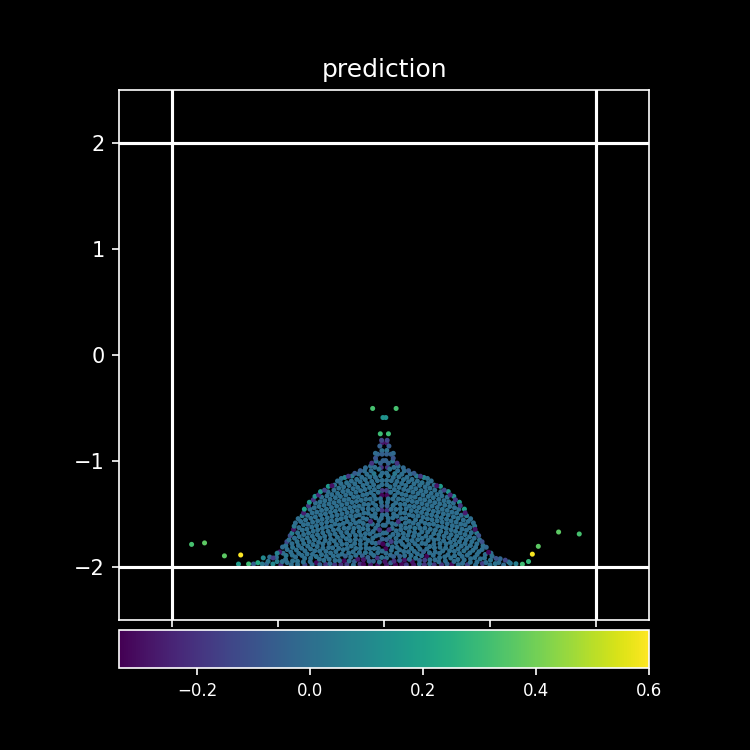

In [81]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
# modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

# debugPrint(modelOutput.shape)

positions = inputData['fluidPosition'].to(device)

fig, axis = plt.subplots(1, 1, figsize=(5,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = (wi - groundTruthData[0][:,-1]).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
predCbar.ax.tick_params(labelsize=8) 


In [82]:
# debugPrint(model.convs[0].coordinateMapping)

In [86]:
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], training[0][1][0][0], 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)

# model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])
model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)



with torch.no_grad():
    model.convs[0].weight[:] = 0.35
    model.convs[1].weight[:] = 0.35

prediction = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

debugPrint(prediction.shape)
debugPrint(prediction[:,0] - groundTruthData[0][:,-1].to(device))

prediction.shape [Size] = torch.Size([802, 1])
prediction[:,0] - groundTruthData[0][:,-1].to(device) [Tensor] = tensor([3.1750, 3.4065, 3.7541, 3.4065, 3.1750, 2.8253, 3.7563, 4.4128, 4.6442,
        4.9532, 5.3029, 4.9532, 4.6442, 4.4128, 3.7563, 2.8253, 3.4840, 4.2967,
        4.9532, 5.6527, 6.0003, 6.3501, 6.3501, 6.3501, 6.0003, 5.6527, 4.9532,
        4.2967, 3.4840, 3.4840, 4.6465, 5.6505, 6.3501, 6.3501, 6.3501, 6.3501,
        6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 5.6505, 4.6465, 3.4840, 3.4840,
        4.6465, 5.6505, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501,
        6.3501, 6.3501, 6.3501, 6.3501, 5.6505, 4.6465, 3.4840, 3.4840, 4.6465,
        5.6505, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501,
        6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 5.6505, 4.6465, 3.4840, 2.8253,
        4.2967, 5.6505, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501,
        6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 6.3501, 5.6505,
        

In [87]:
# widths = [8,8, 2]

# layerDescription ='Layers:'

# inputFeatures = fluidFeatures.shape[1]

# for i, w in enumerate(widths):
#     win = inputFeatures if i == 0 else widths[i-1] + inputFeatures
#     wout = 2 if i == len(widths) - 1 else widths[i]
#     relu = 'placeholder' if i == len(widths) -1 else 'activation'
#     layerDescription = layerDescription + f'''
#     - inFeatures: {win}
#       outFeatures: {wout}
#       dimension: 2
#       bias: False
#       centerLayer: True
#       periodic: False 
#       {relu}: relu    '''
    
# layerDescription = yaml.load(layerDescription, Loader = yaml.Loader)

In [99]:

# fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], training[0][1][0][0], 1 + np.arange(1))
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)


# plotNd(fluidPositions, fluidFeatures, 'features')
# plotNd(boundaryPositions, boundaryFeatures, 'boundary features')
# plotNd(fluidPositions,groundTruthData[0], 'ground truth')

In [100]:

# fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
# bf, bb = radius(boundaryPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)


# debugPrint(i.shape)
# debugPrint(fluidPositions.shape)

# plotNd(fluidPositions, li.unsqueeze(dim=1), 'neighborCount')

In [101]:
# debugPrint(np.float32(attributes['targetNeighbors']))
# debugPrint(np.exp(-1))

In [112]:
#  semi implicit euler, network predicts velocity update
def integrateState(inputPositions, inputVelocities, modelOutput, dt):
    predictedVelocity = modelOutput #inputVelocities +  modelOutput 
    predictedPosition = inputPositions + attributes['dt'] * predictedVelocity
    
    return predictedPosition, predictedVelocity
# velocity loss
def computeLoss(predictedPosition, predictedVelocity, groundTruth, modelOutput):
#     debugPrint(modelOutput.shape)
#     debugPrint(groundTruth.shape)
#     return torch.sqrt((modelOutput - groundTruth[:,-1:].to(device))**2)
    return torch.abs(modelOutput - groundTruth[:,-1:].to(device))
    return torch.linalg.norm(groundTruth[:,2:] - predictedVelocity, dim = 1)

def loadData(dataset, index, unroll = 1):
    fileName, frameIndex, maxRollouts = train_ds[index]

    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(unroll), frameDistance = frameDistance)
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
    
    return attributes, fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, groundTruthData


def loadBatch(bdata, unroll = 1):
    fluidPositions = []
    boundaryPositions = []
    fluidFeatures = []
    boundaryFeatures = []
    fluidBatchIndices = []
    boundaryBatchIndices = []
    groundTruths = []
    for i in range(unroll):
        groundTruths.append([])
    
    for i,b in enumerate(bdata):
#         debugPrint(i)
#         debugPrint(b)
        attribute, fluidPosition, boundaryPosition, fluidFeature, boundaryFeature, groundTruth = loadData(train_ds, b, unroll = unroll)     
#         debugPrint(groundTruth)
        fluidPositions.append(fluidPosition)
#         debugPrint(fluidPositions)
        boundaryPositions.append(boundaryPosition)
        fluidFeatures.append(fluidFeature)
        boundaryFeatures.append(boundaryFeature)
        
        batchIndex = torch.ones(fluidPosition.shape[0], device = device) * i
        fluidBatchIndices.append(batchIndex)
        
        batchIndex = torch.ones(boundaryPosition.shape[0], device = device) * i
        boundaryBatchIndices.append(batchIndex)
        for u in range(unroll):
            groundTruths[u].append(groundTruth[u])
        
    fluidPositions = torch.vstack(fluidPositions)
    boundaryPositions = torch.vstack(boundaryPositions)
    fluidFeatures = torch.vstack(fluidFeatures)
    boundaryFeatures = torch.vstack(boundaryFeatures)
    fluidBatchIndices = torch.hstack(fluidBatchIndices)
    boundaryBatchIndices = torch.hstack(boundaryBatchIndices)
    for u in range(unroll):
        groundTruths[u] = torch.vstack(groundTruths[u])
    
    return fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatchIndices, boundaryBatchIndices, groundTruths
    
def processBatch(bdata, unroll):
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches, groundTruths = loadBatch(bdata, unroll)    
    
    predictedPositions = fluidPositions.to(device)
    predictedVelocity = fluidFeatures[:,1:3].to(device)
    
    unrolledLosses = []
    bLosses = []
#     debugPrint(bdata)
    boundaryPositions = boundaryPositions.to(device)
    fluidFeatures = fluidFeatures.to(device)
    boundaryFeatures = boundaryFeatures.to(device)
    
#     debugPrint(bdata)
#     debugPrint(predictedPosition)
    
    ls = []
    
    for u in range(1):
        predictions = model(predictedPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], fluidBatches, boundaryBatches)

        predictedPositions, predictedVelocities = integrateState(predictedPositions, predictedVelocity, predictions, attributes['dt'])
        
        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], predictedVelocity, fluidFeatures[:,3:]))
#         fluidFeatures[:,1:3] = predictedVelocity

#         debugPrint(prediction.shape)
#         debugPrint(groundTruths[0].shape)
#         loss = model.li * (predictions - groundTruths[0][:,-1:].to(device)) ** 0.5
#         debugPrint(model.li)
#         loss = computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
#         loss = model.li * torch.sqrt(computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions))
#         loss = model.li * computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
        loss = computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
#         p = 8
#         debugPrint(loss[:p,0].detach().cpu().numpy())
#         debugPrint(predictions[:p,0].detach().cpu().numpy())
#         debugPrint(groundTruths[0][:,-1:][:p,0].detach().cpu().numpy())
#         print('----------------------')
        ls.append(torch.mean(loss))
        batchedLoss = []
#         debugPrint(fluidBatches)
        for i in range(len(bdata)):
            L = loss[fluidBatches == i]
#             debugPrint(L)
            Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))
            
            
            batchedLoss.append(torch.hstack(Lterms))
        batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
#         debugPrint(batchedLoss.shape)
        batchLoss = torch.mean(loss)# + torch.max(torch.abs(loss))
        bLosses.append(batchedLoss)
        unrolledLosses.append(batchLoss)
        
#     debugPrint(bLosses)
#     debugPrint(torch.cat(bLosses))
#     debugPrint(bLosses.shape)
#     debugPrint(bLosses)
    
#     return torch.mean(torch.hstack(ls))
    
    bLosses = torch.vstack(bLosses)
    maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
    minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
    meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
    stdLosses = torch.mean(bLosses[:,:,3], dim = 0)
    
    
    del predictedPositions, predictedVelocities, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches
    
    bLosses = bLosses.transpose(0,1)
    
    return bLosses, meanLosses, minLosses, maxLosses, stdLosses



In [114]:
debugPrint(fluidFeatures.shape)

model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], coordinateMapping = 'polar', n = 8, m = 8, windowFn = lambda r: torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0), rbf_x = 'linear', rbf_y = 'linear', batchSize = 64)



lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))


optimizer.zero_grad()

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = 8).batch_sampler

# epoch = 
maxRollOut = 10
model.train()

lossFn = 'v'
shiftSteps = 2
epochs = 100

# frameDistance = 100


fluidFeatures.shape [Size] = torch.Size([802, 1])
Number of parameters 192


In [115]:
# # torch.autograd.set_detect_anomaly(True)

# forwardBatch = backwardBatch = 32
# model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


# lr = 1e-3
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
# model = model.to(device)

# # torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('Number of parameters', count_parameters(model))


# optimizer.zero_grad()

# train_ds = datasetLoader(training)
# train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = 1).batch_sampler

# # epoch = 
# maxRollOut = 10
# model.train()

# lossFn = 'v'
# shiftSteps = 2
# epochs = 100



In [116]:

te = tqdm(range(epochs))
t = tqdm(train_dataloader)

#         t.set_description('%3d [%5d x %5d] @ %1.5e: %1.5e' %(epoch, bdata[0], rollout, lr, sumLosses))
#         t.update()
# #         break
rollout = 4
epochLosses = []
for e in te:
    t.reset(total=len(train_dataloader))
    losses = []
    batchIndices = []
    for bdata in train_dataloader:
        optimizer.zero_grad()
        
        batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(bdata,  1)
#         sumLosses = processBatch(bdata,  1)
        batchIndices.append(np.array(bdata))
        losses.append(batchLosses.detach().cpu().numpy())
        
        sumLosses = torch.mean(batchLosses[:,:,0])
        sumLosses.backward()

        optimizer.step()
#         debugPrint(batchLosses)
#         debugPrint(meanLosses)
    
        lossString = np.array2string(meanLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
        batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
        
#         debugPrint(batchString)
        
        t.set_description('%3d [%5d] @ %1.5e: %s - %s -> %.4e' %(e, rollout, lr, batchString, lossString, sumLosses.detach().cpu().numpy()))
#         t.set_description('%3d [%5d] @ %1.5e: %d - %.4e' %(e, rollout, lr, bdata[0], sumLosses.detach().cpu().numpy()))
        t.update()
    bIndices  = np.hstack(batchIndices)
    losses = np.vstack(losses)

    idx = np.argsort(bIndices)
    bIndices = bIndices[idx]
    losses = losses[idx]

    epochLoss = losses
    epochLosses.append(epochLoss)

#         break
    if e % 1 == 0:
        lr = lr * 0.99
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.99 * param_group['lr']
#     break
        
        

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
# debugPrint(overallLosses.shape)
allLosses = np.vstack([np.expand_dims(e, axis = 0) for e in epochLosses])
debugPrint(allLosses.shape)

allLosses.shape [tuple] = (100, 74, 1, 4)


In [119]:
# debugPrint(model.convs[0].weight)

In [120]:
overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in epochLosses])

<IPython.core.display.Javascript object>


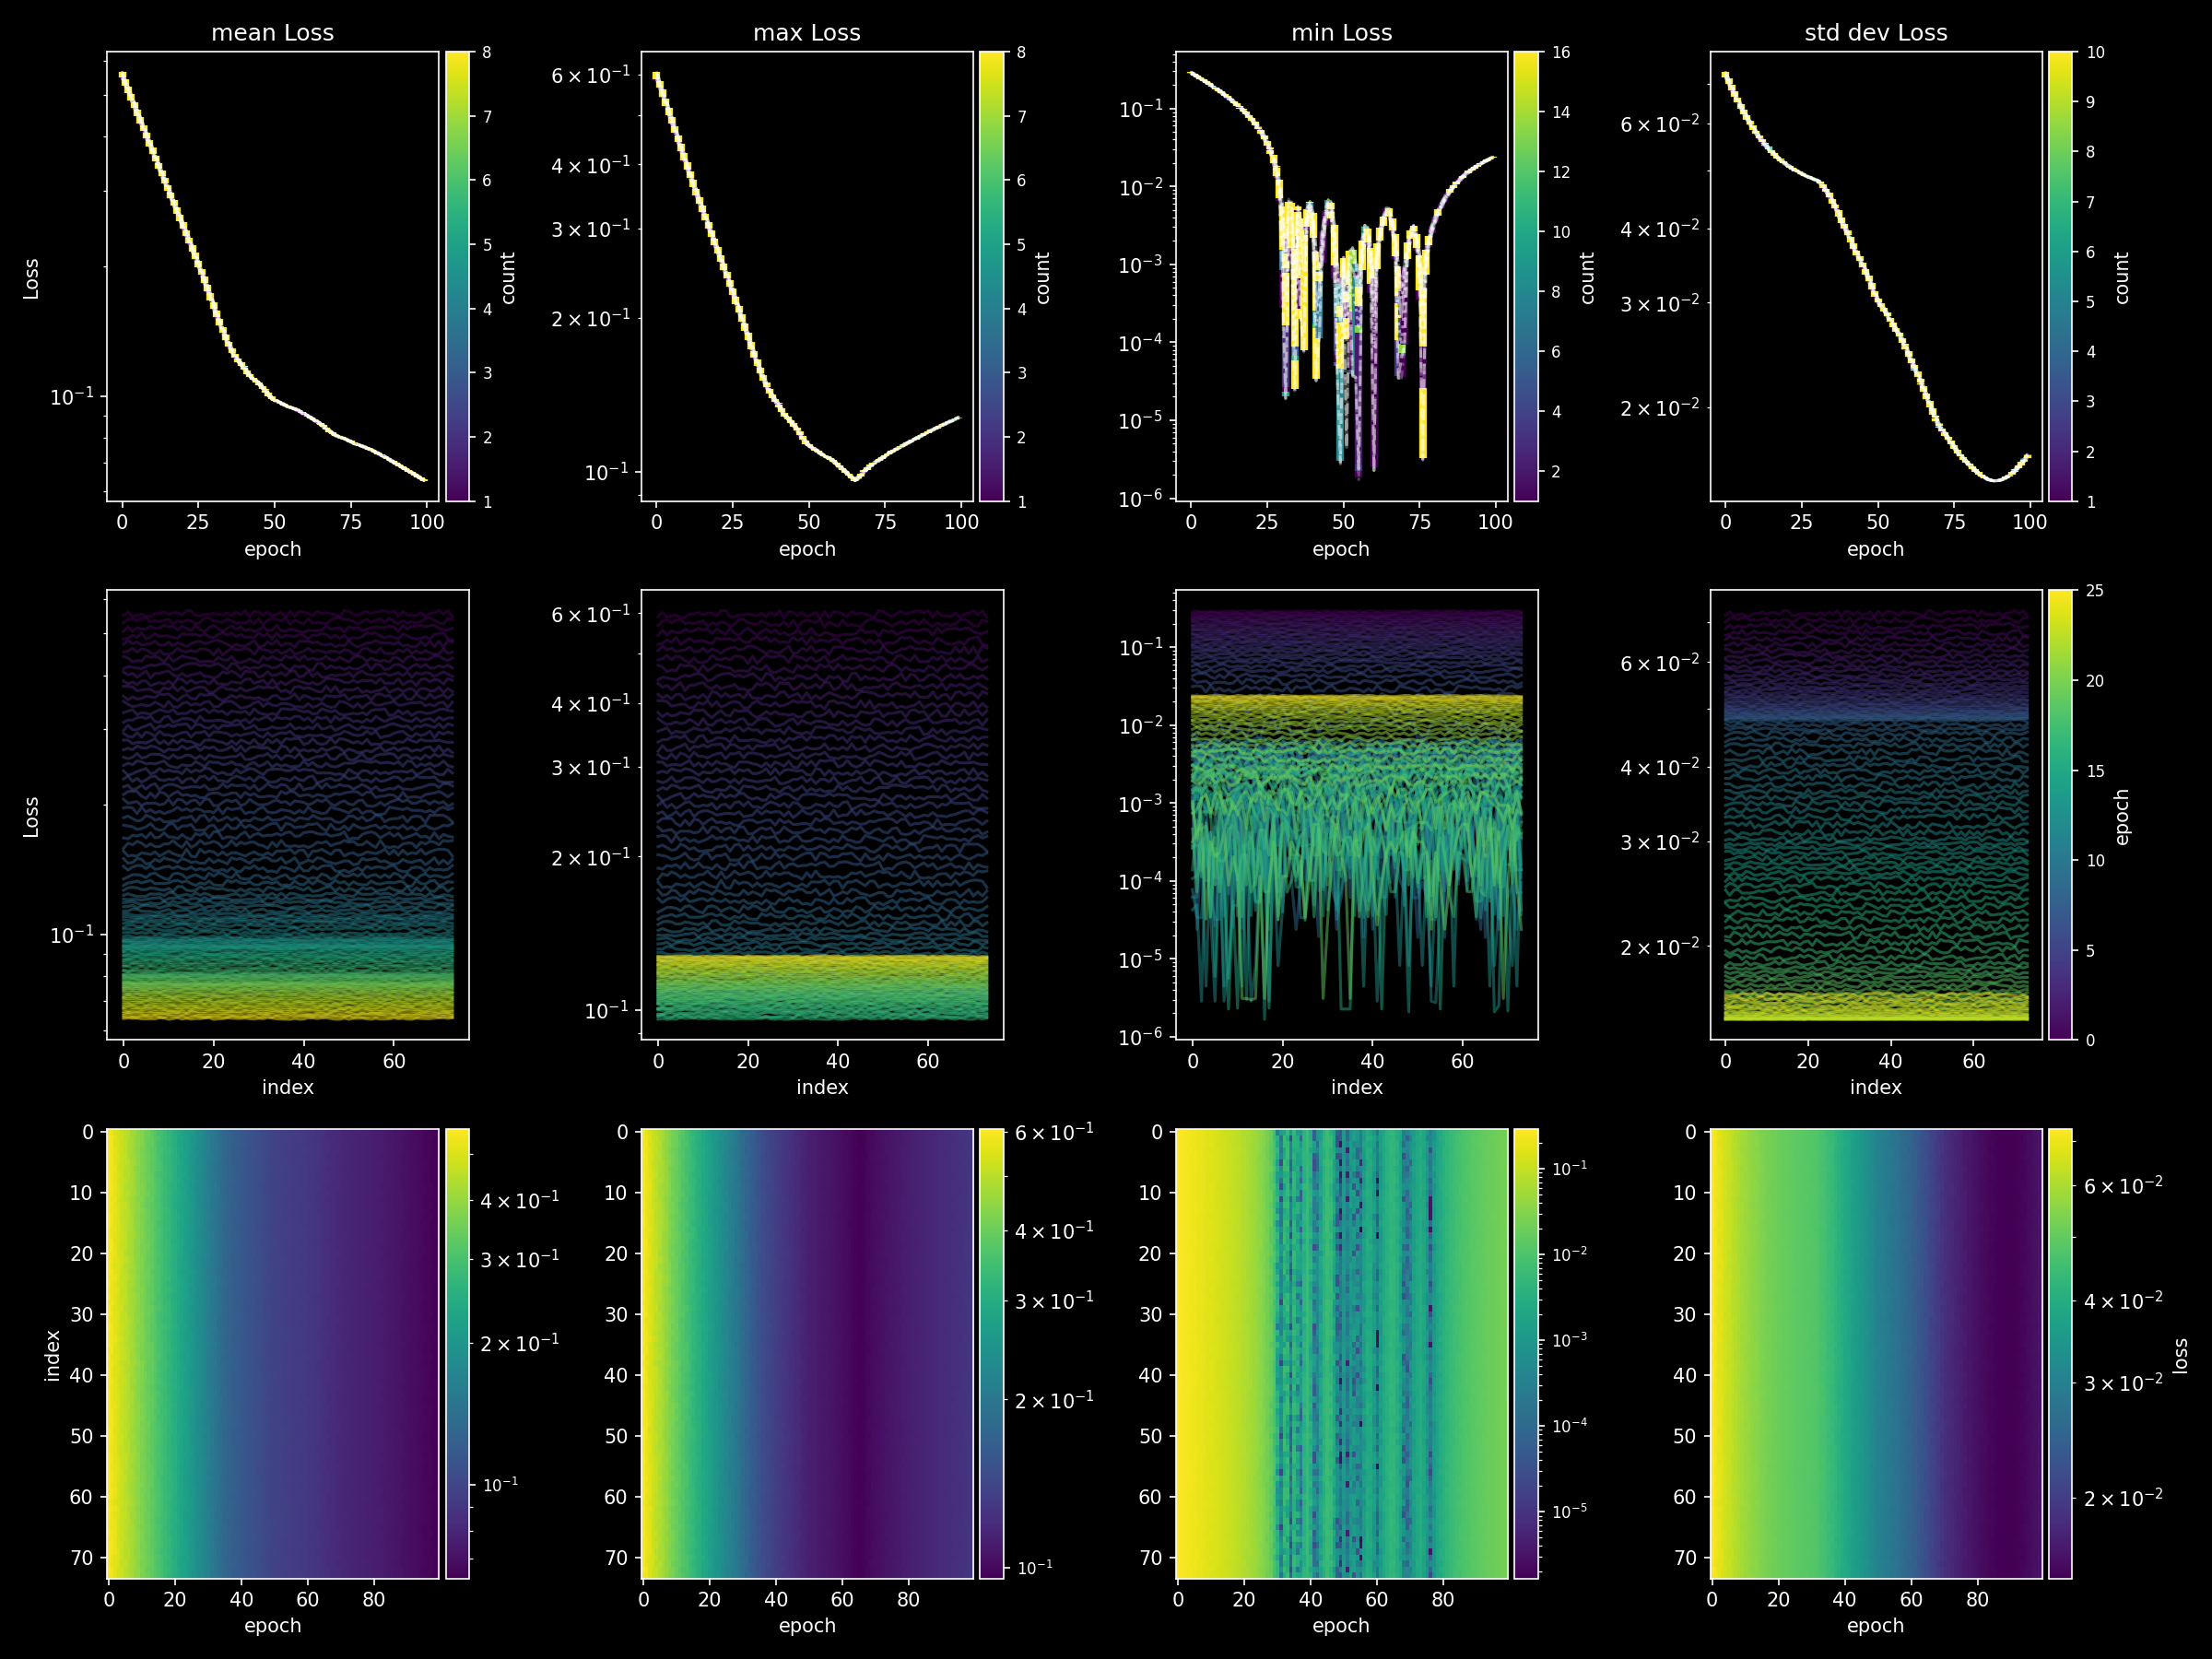

In [121]:
plotLossesv2(epochLosses)

<IPython.core.display.Javascript object>


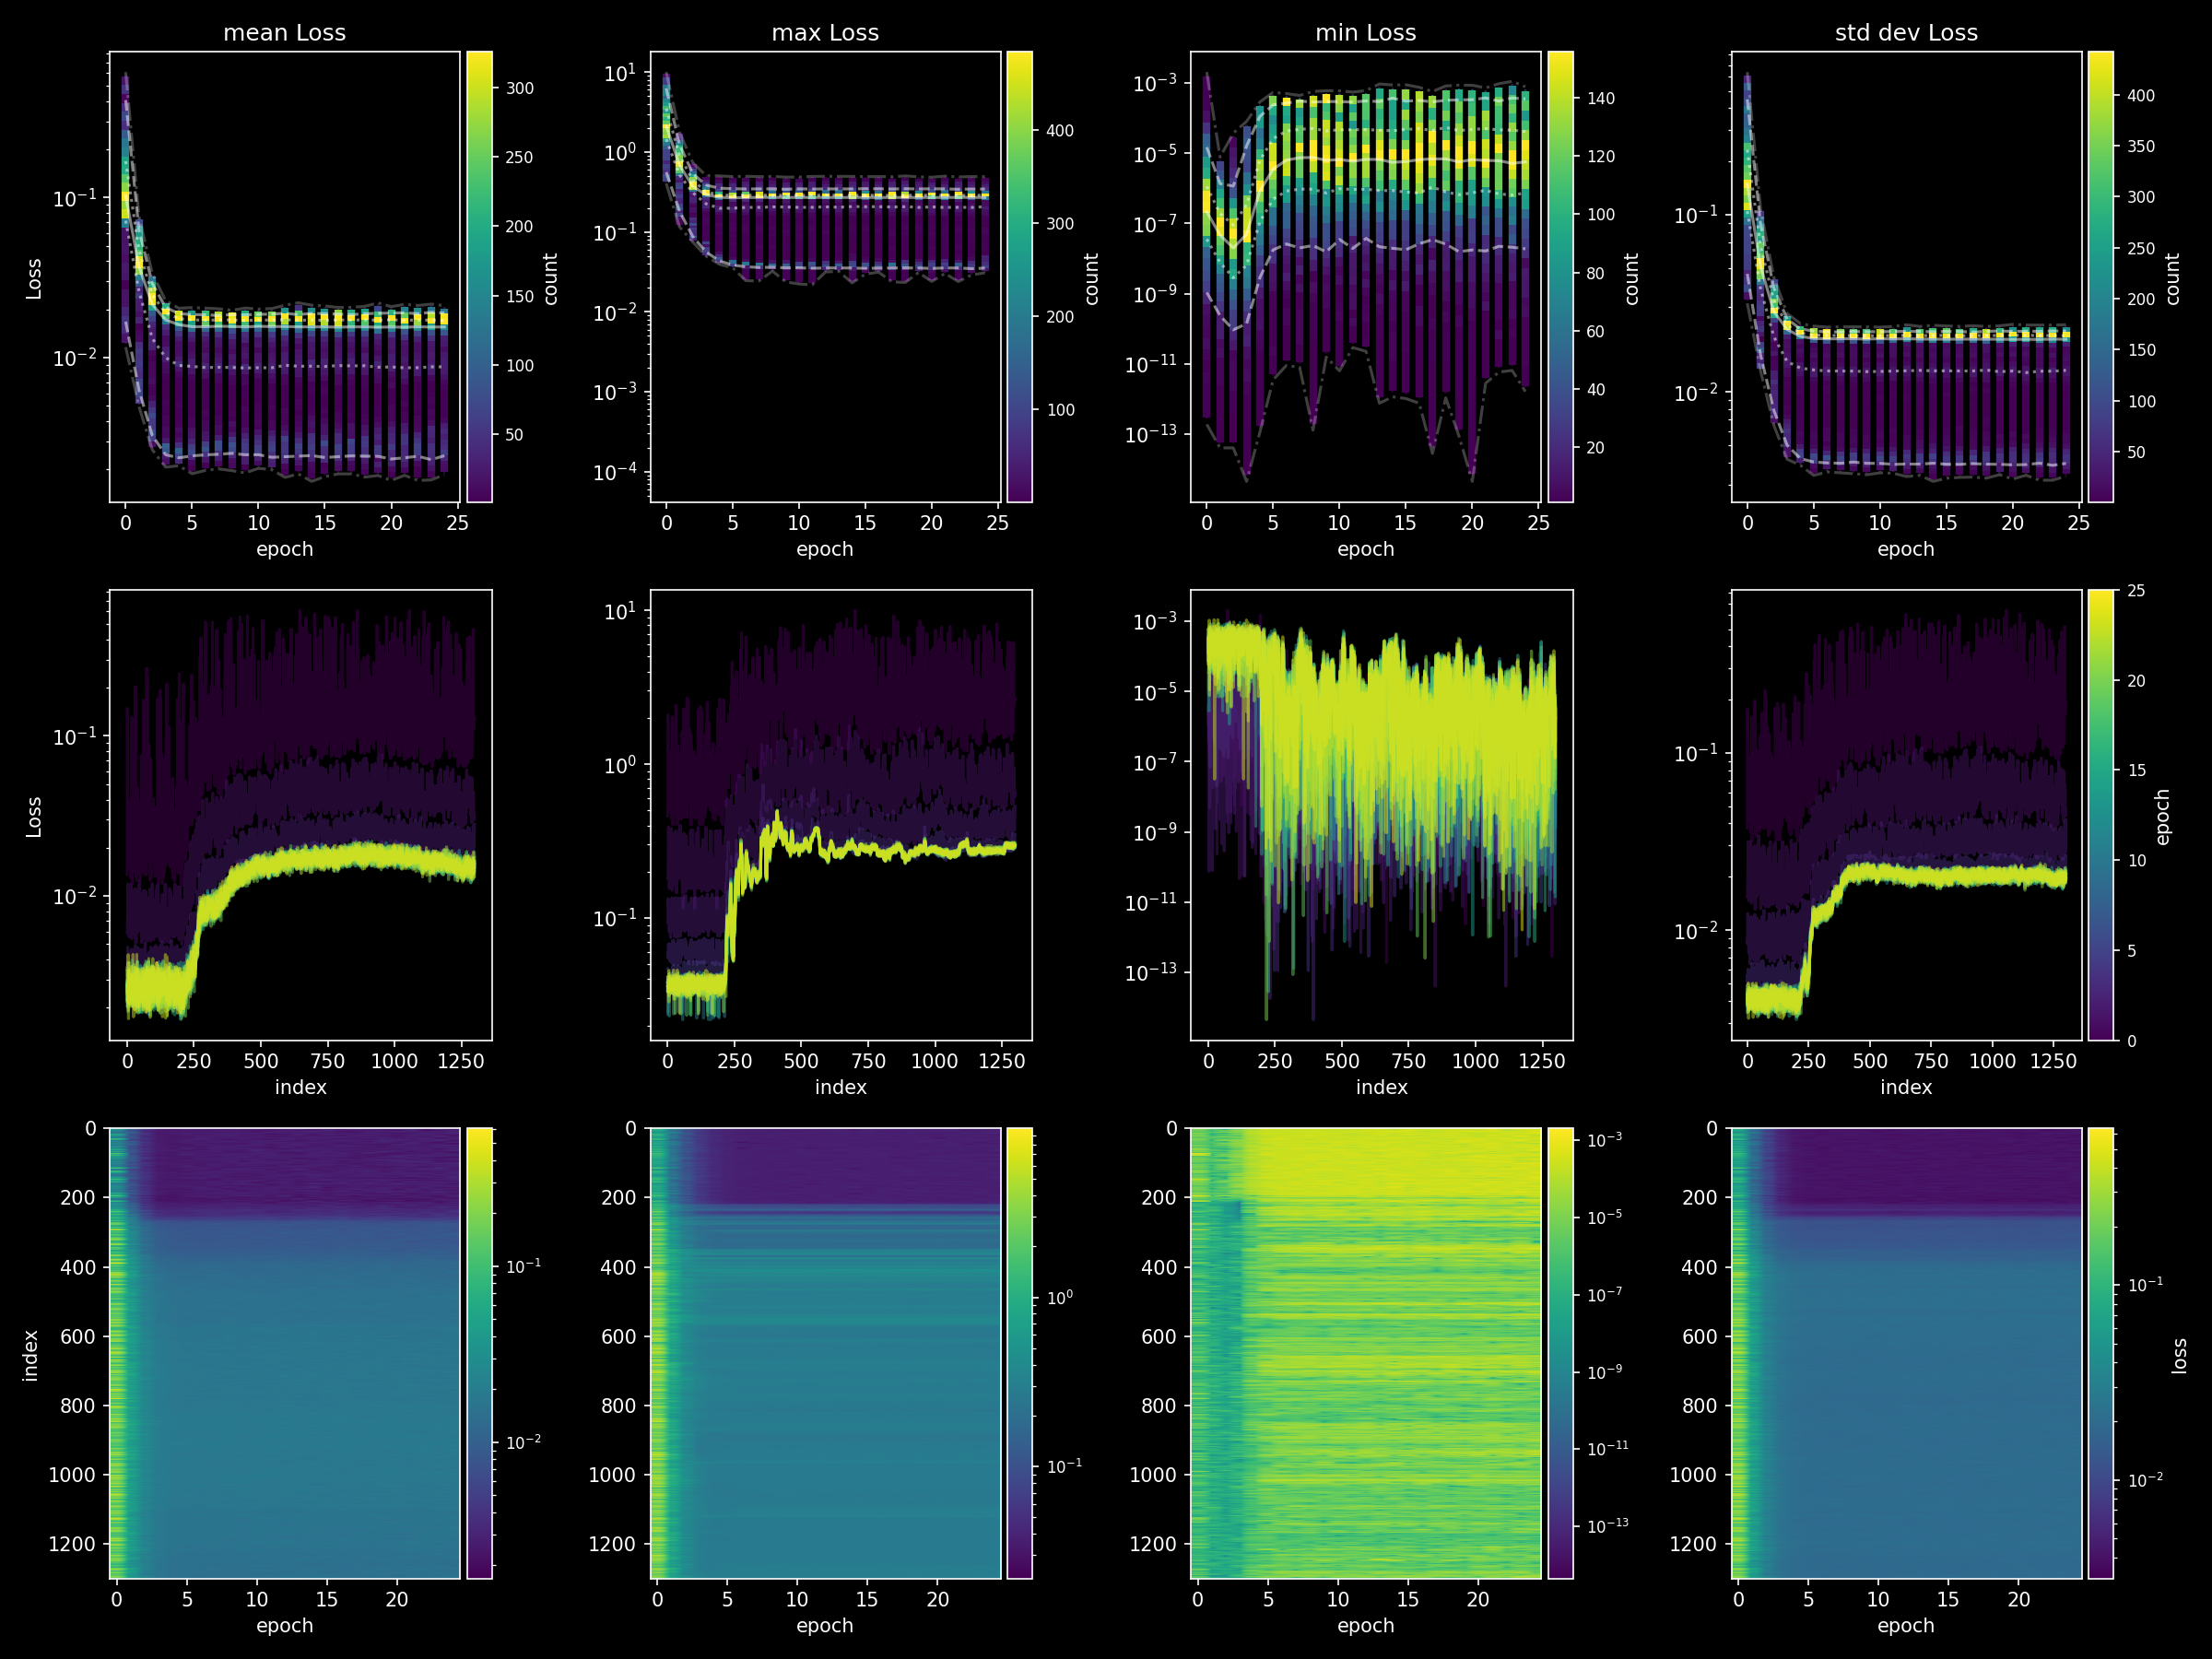

In [30]:
plotLossesv2(epochLosses)

modelOutput.shape [Size] = torch.Size([802, 1])


<IPython.core.display.Javascript object>


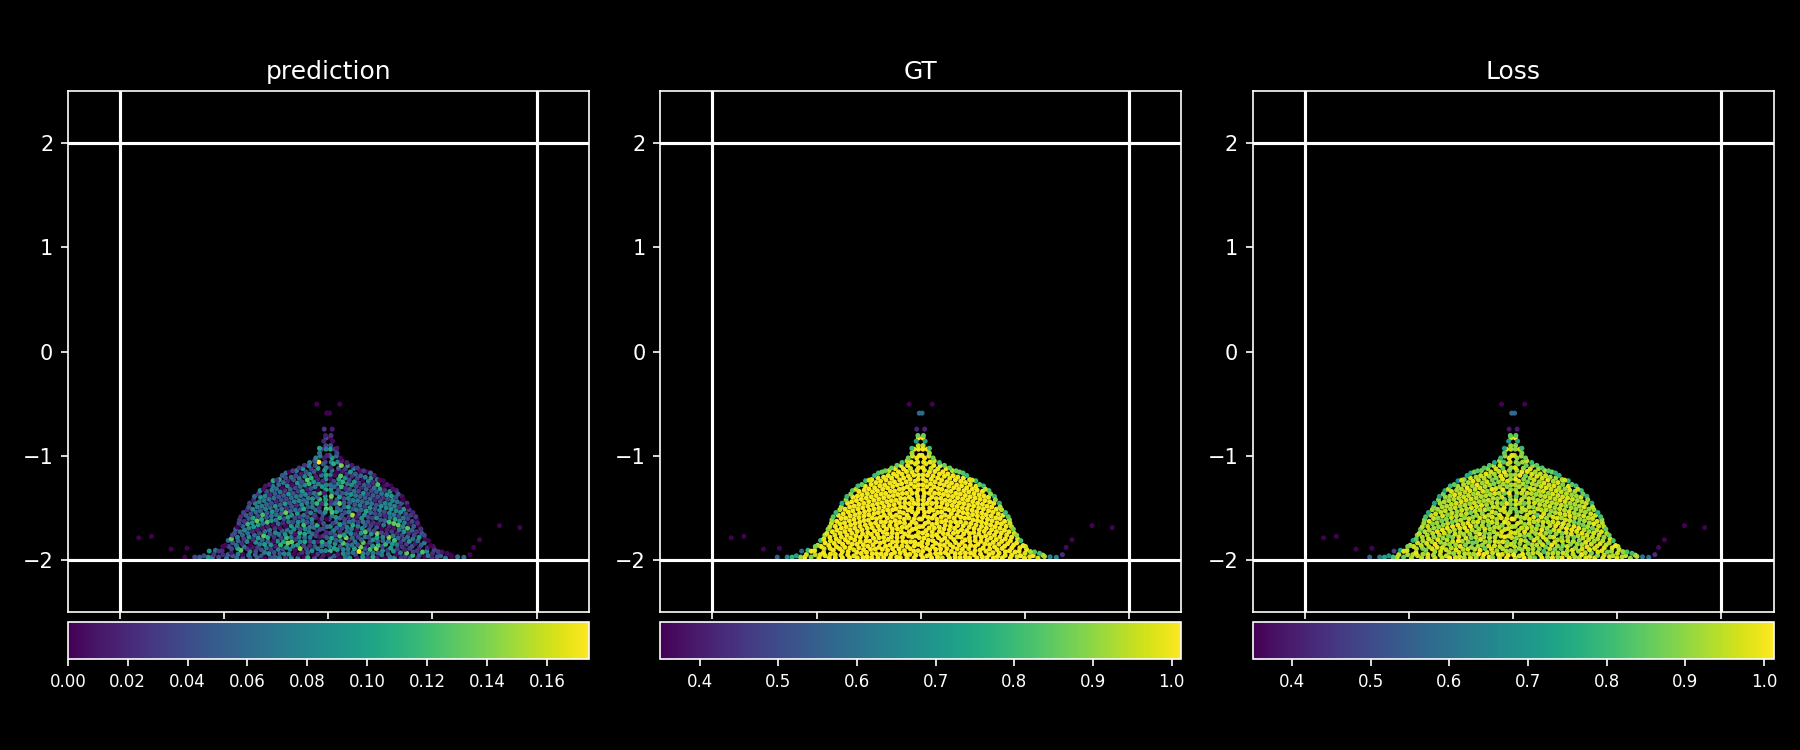

In [78]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

debugPrint(modelOutput.shape)

positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = computeLoss(predictedPosition, predictedVelocity, gt, modelOutput)# (gt[:,-1:] - modelOutput) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 3, figsize=(12,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = modelOutput.detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = (gt[:,-1:] )

axis[0,1].set_title('GT')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


axis[0,2].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,2].scatter(x,y,c = loss.detach().cpu().numpy(), s= 2)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-2.5,2.5)
axis[0,2].set_ylim(-2.5,2.5)
axis[0,2].axvline(-2)
axis[0,2].axvline(2)
axis[0,2].axhline(-2)
axis[0,2].axhline(2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


In [232]:
# debugPrint(fluidFeatures)

In [46]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)


positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt[:,2:] - predictedVelocity, dim = 1) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 2, figsize=(9,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = torch.linalg.norm(gt[:,2:] - predictedVelocity,axis=1).detach().cpu().numpy()

axis[0,1].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v, s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [141]:


# predictedPosition = inputData['fluidPosition'].to(device)
# predictedVelocity = inputData['fluidVelocity'].to(device)

for i in tqdm(range(128)):
#     debugPrint(i)
    fluidFeatures[:,1:3] = predictedVelocity
    
    modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

    newPosition = predictedPosition + attributes['dt'] * predictedVelocity
    newVelocity = predictedVelocity +  modelOutput

    data = (torch.linalg.norm(modelOutput, dim = 1) ** 2).detach().cpu().numpy()
    data = (torch.linalg.norm(newVelocity, dim = 1) ** 2).detach().cpu().numpy()
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    predSC.set_offsets(newPosition.detach().cpu().numpy())
    predSC.set_array(data)

    attributes, inputData, groundTruthData = loadFrame(fileName,frameIndex + 1)
    data = (torch.linalg.norm(inputData['fluidPosition'].to(device) - newPosition, dim = 1) ** 2).detach().cpu().numpy()
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    GTsc.set_offsets(inputData['fluidPosition'].detach().cpu().numpy())
    GTsc.set_array(data)

    predictedPosition = newPosition
    predictedVelocity = newVelocity
    fig.canvas.draw()
    fig.canvas.flush_events()

    frameIndex = frameIndex + 1
# for i in range(8):
#     modelOutput = model(predictedPosition, predictedVelocity, predictedPosition, attrs['support'], None, None)

#     predictedPosition = inputData['fluidPosition'] + attrs['dt'] * inputData['fluidVelocity']
#     predictedVelocity = inputData['fluidVelocity'].to(device) +  modelOutput

#     gt = gtData[0].type(torch.float32).to(device)
    
    
    

  0%|          | 0/128 [00:00<?, ?it/s]